In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_dataset'
    label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_spotting_model_6.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/keyword_spotting_model_6.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torchaudio
from torchvision.transforms import Compose
import os
import torch.nn as nn  # Import torch.nn module
from torch.utils.data import DataLoader, Dataset
import librosa
from torchaudio.transforms import Resample

# Load the saved model
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 20




model_path = '/content/drive/MyDrive/keyword_spotting_model_6.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


# Define the transform to extract features
# transform = Compose([
#     torchaudio.transforms.MFCC(
#         sample_rate=16000,  # Sample rate of the audio file
#         n_mfcc=40,          # Number of MFCC coefficients to extract
#     )
# ])

# Function to predict the class of an audio file
# def predict_class(file_path, model, transform):
#     waveform, sample_rate = torchaudio.load(file_path)
#     if waveform.size(0) == 1:
#       print("The audio is already mono")
#     else:
#       waveform = torch.mean(waveform, dim=0, keepdim=True)

#     # Take the average of the two channels to convert to mono

#     features = transform(waveform).unsqueeze(0)  # Add batch dimension
#     outputs = model(features)
#     _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.data)
#     print(_)
#     print(predicted)
#     return predicted.item()

def pad_or_trim_mfcc(mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length >fixed_length:
            mfcc = mfcc[:, :, :fixed_length]

        return mfcc

# Example usage
audio_file_path = "/content/drive/MyDrive/testing_dataset/aaii_aara_chatrisha/FBNWB19B0035I031.wav"
waveform, sample_rate = torchaudio.load(audio_file_path)

# If the waveform is stereo, convert it to mono
if waveform.size(0) == 2:
    waveform = torch.mean(waveform, dim=0, keepdim=True)


  # Load as mono channel

      # Resample the audio if the sample rate is different from the target


      # Normalize the amplitude to [-1, 1]





mfcc_window_size=0.025
mfcc_window_stride=0.01
mfcc_n_mels=40
fixed_length=500
mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=mfcc_n_mels,
            melkwargs={
                'win_length': int(mfcc_window_size * sample_rate),
                'hop_length': int(mfcc_window_stride * sample_rate),
            }
        )(waveform)
mfcc = pad_or_trim_mfcc(mfcc)
mfcc = mfcc.permute(0, 2, 1)
outputs = model(mfcc.unsqueeze(0))
_, predicted = torch.max(outputs.data, 1)
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
print("Predicted class index:",list(label_map.items())[predicted.item()])


Predicted class index: ('aalura_sanna_caala', 17)


In [ ]:
waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/training_dataset/ad'qahara_d'aala/FBNWB06B0065I047.wav")
sample_rate

8000

In [ ]:
waveform.size()

torch.Size([1, 24000])

In [ ]:
type(waveform)

torch.Tensor

In [ ]:
waveform, sample_rate = librosa.load("/content/drive/MyDrive/training_dataset/ad'qahara_d'aala/FBNWB06B0065I047.wav", sr=None, mono=True)

In [ ]:
c=torch.tensor(waveform)

In [ ]:
c.size()

torch.Size([24000])

In [ ]:
waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/training_dataset/ad'qahara_d'aala/FBNWB06B0065I047.wav")
sample_rate

In [ ]:
import torch
import torchaudio
from torchvision.transforms import Compose
import os
import torch.nn as nn  # Import torch.nn module
from torch.utils.data import DataLoader, Dataset
import librosa
from torchaudio.transforms import Resample

# Load the saved model
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 20




model_path = '/content/drive/MyDrive/keyword_spotting_model_6.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


# Define the transform to extract features
# transform = Compose([
#     torchaudio.transforms.MFCC(
#         sample_rate=16000,  # Sample rate of the audio file
#         n_mfcc=40,          # Number of MFCC coefficients to extract
#     )
# ])

# Function to predict the class of an audio file
# def predict_class(file_path, model, transform):
#     waveform, sample_rate = torchaudio.load(file_path)
#     if waveform.size(0) == 1:
#       print("The audio is already mono")
#     else:
#       waveform = torch.mean(waveform, dim=0, keepdim=True)

#     # Take the average of the two channels to convert to mono

#     features = transform(waveform).unsqueeze(0)  # Add batch dimension
#     outputs = model(features)
#     _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.data)
#     print(_)
#     print(predicted)
#     return predicted.item()

def pad_or_trim_mfcc(mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length >fixed_length:
            mfcc = mfcc[:, :, :fixed_length]

        return mfcc

# Example usage
audio_file_path = "/content/drive/MyDrive/bankura.wav"
waveform, sample_rate = torchaudio.load(audio_file_path)
if waveform.size(0)!=1:
  waveform = torch.mean(waveform, dim=0, keepdim=True)



target_sample_rate = 8000
if sample_rate!=target_sample_rate:
  target_sample_rate = 8000
  resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  waveform = resampler(waveform)
  sample_rate=target_sample_rate

max_amplitude = torch.max(waveform)
min_amplitude =torch.max(waveform)
# Normalize the waveform between -1 and 1
if max_amplitude<=1 and min_amplitude>=-1  :
    max_amplitude1 = torch.max(torch.abs(waveform))
    waveform = waveform / max_amplitude1

mfcc_window_size=0.025
mfcc_window_stride=0.01
mfcc_n_mels=40
fixed_length=500
mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=mfcc_n_mels,
            melkwargs={
                'win_length': int(mfcc_window_size * sample_rate),
                'hop_length': int(mfcc_window_stride * sample_rate),
            }
        )(waveform)
mfcc = pad_or_trim_mfcc(mfcc)
mfcc = mfcc.permute(0, 2, 1)
outputs = model(mfcc.unsqueeze(0))
_, predicted = torch.max(outputs.data, 1)
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
print("Predicted class index:",list(label_map.items())[predicted.item()])


Predicted class index: ("ad'qahara_d'aala", 9)


In [ ]:
sample_rate

8000

In [ ]:
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}

In [ ]:
import os
sou_dir='/content/drive/MyDrive/testing_dataset'
class_names=os.listdir(sou_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
print(label_map)

{"bad'qa_aangura": 0, "baankud'qaaa": 1, "anJa_bad'qa_kalaa": 2, 'anJaanJa_tailabiija': 3, 'anJaanJa_haansa': 4, "baaluraghaat'a": 5, 'baandhaakapi': 6, "anJaanJa_d'ima": 7, "anJa_chot'a_kalaa": 8, "ad'qahara_d'aala": 9, 'anJaanJa_aalu': 10, 'aapela': 11, "aaii_aara_t'oyent'i": 12, 'aalu': 13, 'aalipuraduyaara': 14, "aaii_aara_kud'qi": 15, 'aalura_sanna_caala': 16, 'aama': 17, 'aaii_aara_chatrisha': 18, 'aanaarasa': 19}


In [ ]:
import os
import torch
import torchaudio
from torchvision.transforms import Compose
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np


# Define your TCResNet model and load the pretrained weights
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 20
batch_size=32
fixed_length=500
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc


class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    # Define your model architecture here...

# Load the saved model
model_path ='/content/drive/MyDrive/keyword_spotting_model_6.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Define the transform to extract features
transform = Compose([
    torchaudio.transforms.MFCC(
        sample_rate=16000,  # Sample rate of the audio file
        n_mfcc=40,          # Number of MFCC coefficients to extract
    )
])

# Define your validation dataset
validation_data_dir ='/content/drive/MyDrive/testing_dataset'
validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Function to predict the class of an audio file
def predict_class(file_path, model, transform):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.size(0) == 1:
      print("The audio is already mono")
    else:
      waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Take the average of the two channels to convert to mono

    features = transform(waveform).unsqueeze(0)  # Add batch dimension
    outputs = model(features)
    _, predicted = torch.max(outputs.data, 1)
    return predicted.item()

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)
# Iterate over the validation dataset
# Iterate over the validation dataset
for inputs, labels in validation_dataloader:
    inputs = inputs.squeeze(1)  # Remove the channel dimension (batch_size, 1, bins, frames) -> (batch_size, bins, frames)
    inputs = inputs.to(device)  # Move inputs to device
    labels = labels.to(device)  # Move labels to device

    # Make sure input has only 1 channel
    inputs = inputs.unsqueeze(1) # Select only the first channel

    # Make predictions
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Confusion Matrix:
[[19  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  1  0  1  1  0  0  0  1  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  1  0  0  0  0  0  1  0  0  2  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  1  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  1 17  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  1  0  0  2  0  0  0 15  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  1  1  0  0 16  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  1 17  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0 19  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/speaker_spotting_model.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'0118': 0, '0142': 1, '0149': 2, '0122': 3, '0143': 4, '0147': 5, '0127': 6, '0146': 7, '0135': 8, '0108': 9, '0073': 10, '0106': 11, '0100': 12, '0014': 13, '0009': 14, '0102': 15, '0099': 16, '0041': 17, '0084': 18, '0006': 19}
Epoch [1/50], Loss: 2.9495139932632446
Epoch [2/50], Loss: 2.7924093627929687
Epoch [3/50], Loss: 2.6539785432815552
Epoch [4/50], Loss: 2.527123007774353
Epoch [5/50], Loss: 2.370954647064209
Epoch [6/50], Loss: 2.271669263839722
Epoch [7/50], Loss: 2.1229736375808717
Epoch [8/50], Loss: 2.0101923084259035
Epoch [9/50], Loss: 1.8908518409729005
Epoch [10/50], Loss: 1.7904393458366394
Epoch [11/50], Loss: 1.618246672153473
Epoch [12/50], Loss: 1.4680297923088075
Epoch [13/50], Loss: 1.320442681312561
Epoch [14/50], Loss: 1.194735586643219
Epoch [15/50], Loss: 1.1210867166519165
Epoch [16/50], Loss: 0.9539926409721374
Epoch [17/50], Loss: 0.8170857137441635
Epoch [18/50], Loss: 0.7231274038553238
Epoch [19/50], Loss: 0.5983017748594284
Epoch [20/50], Loss: 0.4

In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset


data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

# Define the dataset class
class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {class_name: idx for idx, class_name in enumerate(label_map)}
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names = os.listdir(data_dir)
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load the saved model
    model_path = '/content/drive/MyDrive/speaker_spotting_model.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.train()  # Set model to training mode

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model for additional epochs
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the updated model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model_updated.pth')
    validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_saved_model('/content/drive/MyDrive/speaker_spotting_model_updated.pth', validation_dataloader, device)
if __name__ == "__main__":
    main()

Epoch [1/10], Loss: 0.1467542373528704
Epoch [2/10], Loss: 0.10414267241954804
Epoch [3/10], Loss: 0.08488971516489982
Epoch [4/10], Loss: 0.06052946258336306
Epoch [5/10], Loss: 0.14050185441970825
Epoch [6/10], Loss: 0.1127864619717002
Epoch [7/10], Loss: 0.10904358629137277
Epoch [8/10], Loss: 0.08482573207467795
Epoch [9/10], Loss: 0.06355442682281137
Epoch [10/10], Loss: 0.04759636629372835
Validation Accuracy of the saved model: 62.75%


In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset


data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

# Define the dataset class
class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {class_name: idx for idx, class_name in enumerate(label_map)}
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names = os.listdir(data_dir)
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load the saved model
    model_path = '/content/drive/MyDrive/speaker_spotting_model_updated.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.train()  # Set model to training mode

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model for additional epochs
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the updated model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model_updated_1.pth')
    validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_saved_model('/content/drive/MyDrive/speaker_spotting_model_updated_1.pth', validation_dataloader, device)
if __name__ == "__main__":
    main()

Epoch [1/10], Loss: 0.1173825503513217
Epoch [2/10], Loss: 0.10740462448447943
Epoch [3/10], Loss: 0.10052462661638856
Epoch [4/10], Loss: 0.030875644106417896
Epoch [5/10], Loss: 0.009279043045826257
Epoch [6/10], Loss: 0.007782989935949444
Epoch [7/10], Loss: 0.005618911295896396
Epoch [8/10], Loss: 0.0024156421527732163
Epoch [9/10], Loss: 0.001341382401296869
Epoch [10/10], Loss: 0.0017499962920555846
Validation Accuracy of the saved model: 67.00%


In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset


data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

# Define the dataset class
class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {class_name: idx for idx, class_name in enumerate(label_map)}
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names = os.listdir(data_dir)
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load the saved model
    model_path = '/content/drive/MyDrive/speaker_spotting_model_updated_1.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.train()  # Set model to training mode

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model for additional epochs
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the updated model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model_updated_2.pth')
    validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_saved_model('/content/drive/MyDrive/speaker_spotting_model_updated_2.pth', validation_dataloader, device)
if __name__ == "__main__":
    main()

Epoch [1/10], Loss: 0.06728889818885364
Epoch [2/10], Loss: 0.11582761101424693
Epoch [3/10], Loss: 0.10087040040642023
Epoch [4/10], Loss: 0.07732015829533338
Epoch [5/10], Loss: 0.03970345253124833
Epoch [6/10], Loss: 0.023391819056123496
Epoch [7/10], Loss: 0.014391174898482859
Epoch [8/10], Loss: 0.01320849381852895
Epoch [9/10], Loss: 0.024677844303660094
Epoch [10/10], Loss: 0.07869688289240002
Validation Accuracy of the saved model: 58.25%


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 70
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model_1.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/speaker_spotting_model_1.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'0118': 0, '0142': 1, '0149': 2, '0122': 3, '0143': 4, '0147': 5, '0127': 6, '0146': 7, '0135': 8, '0108': 9, '0073': 10, '0106': 11, '0100': 12, '0014': 13, '0009': 14, '0102': 15, '0099': 16, '0041': 17, '0084': 18, '0006': 19}
Epoch [1/70], Loss: 2.9709414529800413
Epoch [2/70], Loss: 2.8555618810653685
Epoch [3/70], Loss: 2.726030430793762
Epoch [4/70], Loss: 2.5959487438201903
Epoch [5/70], Loss: 2.4297839307785036
Epoch [6/70], Loss: 2.341527009010315
Epoch [7/70], Loss: 2.213525950908661
Epoch [8/70], Loss: 2.111702995300293
Epoch [9/70], Loss: 1.963126814365387
Epoch [10/70], Loss: 1.864241771697998
Epoch [11/70], Loss: 1.732000651359558
Epoch [12/70], Loss: 1.5751424956321716
Epoch [13/70], Loss: 1.46021320104599
Epoch [14/70], Loss: 1.39758819937706
Epoch [15/70], Loss: 1.1876923048496246
Epoch [16/70], Loss: 1.0353247392177582
Epoch [17/70], Loss: 0.9225025129318237
Epoch [18/70], Loss: 0.8088839465379715
Epoch [19/70], Loss: 0.7049153435230255
Epoch [20/70], Loss: 0.586013

In [ ]:
import torch
import torchaudio
from torchvision.transforms import Compose
import os
import torch.nn as nn  # Import torch.nn module
from torch.utils.data import DataLoader, Dataset

# Load the saved model
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 20
data_dir = '/content/drive/MyDrive/training_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
data_dir1 = '/content/drive/MyDrive/training_Speakers_dataset'
class_names1=os.listdir(data_dir1)
label_map1={class_name: idx for idx,class_name in enumerate(class_names1)}
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x




model_path = '/content/drive/MyDrive/keyword_spotting_model_6.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model_path1 = '/content/drive/MyDrive/speaker_spotting_model.pth'
model1 = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model1.load_state_dict(torch.load(model_path1, map_location=torch.device('cpu')))
model1.eval()

# Define the transform to extract features
transform = Compose([
    torchaudio.transforms.MFCC(
        sample_rate=16000,  # Sample rate of the audio file
        n_mfcc=40,          # Number of MFCC coefficients to extract
    )
])

# Function to predict the class of an audio file
def predict_class(file_path, model, transform):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.size(0) == 1:
      print("The audio is already mono")
    else:
      waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Take the average of the two channels to convert to mono

    features = transform(waveform).unsqueeze(0)  # Add batch dimension
    outputs = model(features)
    _, predicted = torch.max(outputs.data, 1)
    print(outputs)
    print(outputs.data)
    print(_)
    print(predicted)
    return predicted.item()

# Example usage
audio_file_path = '/content/drive/MyDrive/training_Speakers_dataset/0009/FBNWB01B0009I036.wav'
predicted_class_index = predict_class(audio_file_path, model, transform)
predicted_speaker_index = predict_class(audio_file_path, model1, transform)
print("Predicted class index:", list(label_map.items())[predicted_class_index])
print("Predicted speaker index:", list(label_map1.items())[predicted_speaker_index])

The audio is already mono
tensor([[ -79.2868,  128.0415, -152.2669,  -72.4877,  -18.9672,  -46.3931,
         -149.1107,  -49.5355,  -39.7881,  -85.2858,   64.6844,  -28.6762,
          153.4448,  -86.6532, -128.2800,  -98.2132,  -29.3943,  -29.9324,
         -137.2670,  -32.1713]], grad_fn=<AddmmBackward0>)
tensor([[ -79.2868,  128.0415, -152.2669,  -72.4877,  -18.9672,  -46.3931,
         -149.1107,  -49.5355,  -39.7881,  -85.2858,   64.6844,  -28.6762,
          153.4448,  -86.6532, -128.2800,  -98.2132,  -29.3943,  -29.9324,
         -137.2670,  -32.1713]])
tensor([153.4448])
tensor([12])
The audio is already mono
tensor([[-12.9864,   4.8964,   0.1180, -26.3453,  -2.3622, -11.7190, -27.7962,
          23.4866, -15.6716,  -4.3217, -10.6815, -12.3820,  -1.8832, -30.7854,
         -33.4417,  -2.7797,  -2.8027, -11.6420, -21.8771,   6.1512]],
       grad_fn=<AddmmBackward0>)
tensor([[-12.9864,   4.8964,   0.1180, -26.3453,  -2.3622, -11.7190, -27.7962,
          23.4866, -15.6716,  -4.

In [ ]:
import torch
import torchaudio
from torchvision.transforms import Compose
import os
import torch.nn as nn  # Import torch.nn module
from torch.utils.data import DataLoader, Dataset
import librosa
from torchaudio.transforms import Resample

# Load the saved model
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 20

class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x




model_path = '/content/drive/MyDrive/keyword_spotting_model_6.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model_path1 = '/content/drive/MyDrive/speaker_spotting_model.pth'
model1 = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model1.load_state_dict(torch.load(model_path1, map_location=torch.device('cpu')))
model1.eval()





def pad_or_trim_mfcc(mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length >fixed_length:
            mfcc = mfcc[:, :, :fixed_length]

        return mfcc

# Example usage
audio_file_path = "/content/drive/MyDrive/testing_Speakers_dataset/0041/FBNWB03B0041I040.wav"
waveform, sample_rate = torchaudio.load(audio_file_path)
if waveform.size(0)!=1:
  waveform = torch.mean(waveform, dim=0, keepdim=True)



target_sample_rate = 16000
if sample_rate!=target_sample_rate:
  target_sample_rate = 16000
  resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  waveform = resampler(waveform)
  sample_rate=target_sample_rate

max_amplitude = torch.max(waveform)
min_amplitude =torch.max(waveform)
# Normalize the waveform between -1 and 1
if max_amplitude<=1 and min_amplitude>=-1  :
    max_amplitude1 = torch.max(torch.abs(waveform))
    waveform = waveform / max_amplitude1

mfcc_window_size=0.025
mfcc_window_stride=0.01
mfcc_n_mels=40
fixed_length=500
mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=mfcc_n_mels,
            melkwargs={
                'win_length': int(mfcc_window_size * sample_rate),
                'hop_length': int(mfcc_window_stride * sample_rate),
            }
        )(waveform)
mfcc = pad_or_trim_mfcc(mfcc)
mfcc = mfcc.permute(0, 2, 1)
outputs = model(mfcc.unsqueeze(0))
_, predicted = torch.max(outputs.data, 1)
print(outputs.data)
outputs1 = model1(mfcc.unsqueeze(0))
_, predicted1 = torch.max(outputs1.data, 1)
print(outputs1.data)
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
print("Predicted class index:",list(label_map.items())[predicted.item()])
data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names1=os.listdir(data_dir)
label_map1={class_name: idx for idx,class_name in enumerate(class_names1)}
print("Predicted speaker index:",list(label_map1.items())[predicted1.item()])
import torch

def calculate_class_percentage(outputs):
    # Apply softmax to convert raw outputs to probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Extract the probabilities for each class
    class_probabilities = probabilities[0].tolist()  # Assuming outputs is of shape (1, num_classes)

    return class_probabilities

p1=calculate_class_percentage(outputs)
p2=calculate_class_percentage(outputs1)
print(p1)
print(p2)


tensor([[ -9.2131,  -4.9201,  -4.1231,  -1.3675,  -5.2944,  -3.1048,  -2.7841,
          -1.2166, -10.6023,  -2.6844,  -1.4464,  -3.4874, -12.1912, -10.0813,
          -9.4554,  -8.2178,  -6.6966,  -6.2942,  -9.1473,  -9.3825]])
tensor([[-10.2057,  -9.0569,  -2.2627,  -6.6084,  -7.0845,  -4.2889,  -5.4611,
          -3.4328,  -5.5955, -11.1769,  -8.1311,   1.0151,   0.4642,  -1.1504,
           1.9648,  -5.1953,  -4.2075,   8.8083,  -6.1464,   4.8413]])
Predicted class index: ('anJaanJa_tailabiija', 7)
Predicted speaker index: ('0041', 17)
[9.737223444972187e-05, 0.007126555312424898, 0.015811603516340256, 0.2487250566482544, 0.00490104453638196, 0.04377659782767296, 0.060329731553792953, 0.28925129771232605, 2.427164690743666e-05, 0.06665221601724625, 0.2298642247915268, 0.029858840629458427, 4.955060376232723e-06, 4.086549233761616e-05, 7.642036507604644e-05, 0.0002634456614032388, 0.0012059294385835528, 0.0018033537780866027, 0.00010399498569313437, 8.220222662203014e-05]
[5.4123936

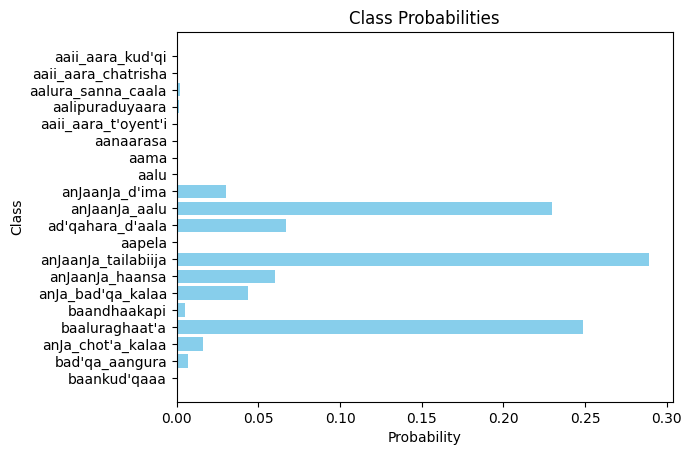

In [ ]:

import matplotlib.pyplot as plt
label_map = {"baankud'qaaa": 0, "bad'qa_aangura": 1, "anJa_chot'a_kalaa": 2, "baaluraghaat'a": 3, "baandhaakapi": 4, "anJa_bad'qa_kalaa": 5, "anJaanJa_haansa": 6, "anJaanJa_tailabiija": 7, "aapela": 8, "ad'qahara_d'aala": 9,"anJaanJa_aalu": 10, "anJaanJa_d'ima": 11, "aalu": 12, "aama": 13, "aanaarasa": 14, "aaii_aara_t'oyent'i": 15, "aalipuraduyaara": 16, "aalura_sanna_caala": 17, "aaii_aara_chatrisha": 18, "aaii_aara_kud'qi": 19}
def plot_class_probabilities(class_probabilities, class_labels):
    # Plotting the class probabilities
    fig, ax = plt.subplots()
    ax.barh(list(class_labels.keys()), class_probabilities, color='skyblue')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Class')
    ax.set_title('Class Probabilities')
    plt.show()
plot_class_probabilities(p1, label_map)

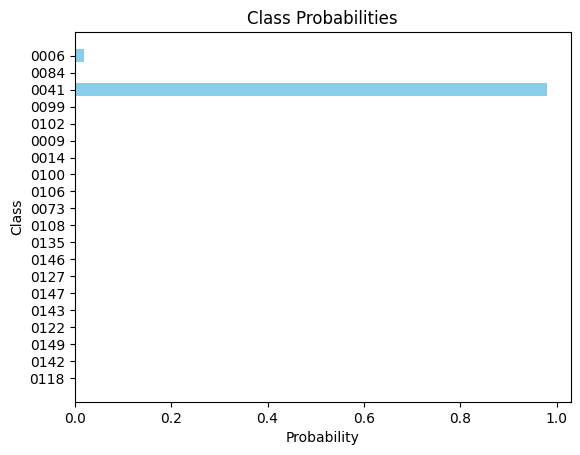

In [ ]:

import matplotlib.pyplot as plt
data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names1=os.listdir(data_dir)
label_map1={class_name: idx for idx,class_name in enumerate(class_names1)}
def plot_class_probabilities(class_probabilities, class_labels):
    # Plotting the class probabilities
    fig, ax = plt.subplots()
    ax.barh(list(class_labels.keys()), class_probabilities, color='skyblue')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Class')
    ax.set_title('Class Probabilities')
    plt.show()
plot_class_probabilities(p2, label_map1)

In [ ]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset


data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

# Define the dataset class
class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {class_name: idx for idx, class_name in enumerate(label_map)}
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg + torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_dataset'
    class_names = os.listdir(data_dir)
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load the saved model
    model_path = '/content/drive/MyDrive/keyword_spotting_model_6.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.train()  # Set model to training mode

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model for additional epochs
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the updated model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_spotting_model_6_updated_1.pth')
    validation_data_dir = '/content/drive/MyDrive/testing_dataset'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_saved_model('/content/drive/MyDrive/keyword_spotting_model_6_updated_1.pth', validation_dataloader, device)
if __name__ == "__main__":
    main()

Epoch [1/10], Loss: 2.924781606197357
Epoch [2/10], Loss: 0.6383559173345565
Epoch [3/10], Loss: 0.24158037588000297
Epoch [4/10], Loss: 0.1288180309534073
Epoch [5/10], Loss: 0.09747257977724075
Epoch [6/10], Loss: 0.05562030494213104
Epoch [7/10], Loss: 0.026374758817255498
Epoch [8/10], Loss: 0.016677936483174564
Epoch [9/10], Loss: 0.011654167482629419
Epoch [10/10], Loss: 0.009184601455926896
Validation Accuracy of the saved model: 84.75%


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
class_names=os.listdir(data_dir)
label_map={class_name: idx for idx,class_name in enumerate(class_names)}
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_Speakers_dataset'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/speaker_spotting_model.pth')

    # Create the dataset and dataloader for validation
    # validation_data_dir = '/content/drive/MyDrive/testing_Speakers_dataset'
    # validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    # validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # # Test the saved model with the validation dataset
    # test_saved_model('/content/drive/MyDrive/speaker_spotting_model.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'0118': 0, '0142': 1, '0149': 2, '0122': 3, '0143': 4, '0147': 5, '0127': 6, '0146': 7, '0135': 8, '0108': 9, '0073': 10, '0106': 11, '0100': 12, '0014': 13, '0009': 14, '0102': 15, '0099': 16, '0041': 17, '0084': 18, '0006': 19}
Epoch [1/50], Loss: 2.9495139932632446
Epoch [2/50], Loss: 2.7924093627929687
Epoch [3/50], Loss: 2.6539785432815552
Epoch [4/50], Loss: 2.527123007774353
Epoch [5/50], Loss: 2.370954647064209
Epoch [6/50], Loss: 2.271669263839722
Epoch [7/50], Loss: 2.1229736375808717
Epoch [8/50], Loss: 2.0101923084259035
Epoch [9/50], Loss: 1.8908518409729005
Epoch [10/50], Loss: 1.7904393458366394
Epoch [11/50], Loss: 1.618246672153473
Epoch [12/50], Loss: 1.4680297923088075
Epoch [13/50], Loss: 1.320442681312561
Epoch [14/50], Loss: 1.194735586643219
Epoch [15/50], Loss: 1.1210867166519165
Epoch [16/50], Loss: 0.9539926409721374
Epoch [17/50], Loss: 0.8170857137441635
Epoch [18/50], Loss: 0.7231274038553238
Epoch [19/50], Loss: 0.5983017748594284
Epoch [20/50], Loss: 0.4

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = 21
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_keywords'
    label_map = {}

    for i in range(21):
      key = f"{i:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_unknown.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_keywords'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20}


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/50], Loss: 2.8701979247006504
Epoch [2/50], Loss: 2.5073325634002686
Epoch [3/50], Loss: 2.230002533305775
Epoch [4/50], Loss: 1.9740379615263506
Epoch [5/50], Loss: 1.696793176911094
Epoch [6/50], Loss: 1.4588215784593062
Epoch [7/50], Loss: 1.263572627847845
Epoch [8/50], Loss: 1.0549371242523193
Epoch [9/50], Loss: 0.8651745644482699
Epoch [10/50], Loss: 0.7356133948672902
Epoch [11/50], Loss: 0.614414328878576
Epoch [12/50], Loss: 0.5083629786968231
Epoch [13/50], Loss: 0.4188829389485446
Epoch [14/50], Loss: 0.365045501427217
Epoch [15/50], Loss: 0.334569280797785
Epoch [16/50], Loss: 0.2754190509969538
Epoch [17/50], Loss: 0.20581930333917792
Epoch [18/50], Loss: 0.16845078359950671
Epoch [19/50], Loss: 0.14178822934627533
Epoch [20/50], Loss: 0.10441598600961945
Epoch [21/50], Loss: 0.08263196999376471
Epoch [22/50], Loss: 0.08399161662567746
Epoch [23/50], Loss: 0.07688694582744078
Epoch [24/50], Loss: 0.07270827415314587
Epoch [25/50], Loss: 0.060992390594699165
Epoch

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_keywords'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

    # Generate and print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_keywords'
    label_map = {}

    for i in range(21):
      key = f"{i:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_keywords'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset and generate confusion matrix
    test_saved_model('/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20}


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Validation Accuracy of the saved model: 83.72%
Confusion Matrix:
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Rest of the code remains unchanged...

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_speakers'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_speakers'
    label_map = {}
    for i in range(21):
      key = f"{i:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_unknown.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_speakers'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20}


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/50], Loss: 2.6277717677029697
Epoch [2/50], Loss: 1.867983796379783
Epoch [3/50], Loss: 1.3932546702298252
Epoch [4/50], Loss: 1.0552752343091099
Epoch [5/50], Loss: 0.7790968309749257
Epoch [6/50], Loss: 0.581100192936984
Epoch [7/50], Loss: 0.4047762453556061
Epoch [8/50], Loss: 0.2758385931903666
Epoch [9/50], Loss: 0.25554009865630756
Epoch [10/50], Loss: 0.18784923716024918
Epoch [11/50], Loss: 0.1581945229660381
Epoch [12/50], Loss: 0.11154821447350761
Epoch [13/50], Loss: 0.08285175568678162
Epoch [14/50], Loss: 0.07254724949598312
Epoch [15/50], Loss: 0.06336434964429248
Epoch [16/50], Loss: 0.08389557085253975
Epoch [17/50], Loss: 0.08604972504756668
Epoch [18/50], Loss: 0.06858701970089566
Epoch [19/50], Loss: 0.050923278385942634
Epoch [20/50], Loss: 0.0586988590657711
Epoch [21/50], Loss: 0.03737586008554155
Epoch [22/50], Loss: 0.01770667333833196
Epoch [23/50], Loss: 0.012606319421055641
Epoch [24/50], Loss: 0.009218261111527681
Epoch [25/50], Loss: 0.00884873407

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np


# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_speakers'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

    # Generate and print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main():
    # Define the parameters
    label_map = {}

    for i in range(21):
      key = f"{i:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_speakers'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset and generate confusion matrix
    test_saved_model('/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20}
Validation Accuracy of the saved model: 97.62%
Confusion Matrix:
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 

In [ ]:
import torch
import torchaudio
from torchvision.transforms import Compose
import os
import torch.nn as nn  # Import torch.nn module
from torch.utils.data import DataLoader, Dataset
import librosa
from torchaudio.transforms import Resample

# Load the saved model
bins = 40
channels = [64, 128, 256, 512]
channel_scale = 1
num_classes = 21

class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x




model_path = '/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_unknown.pth'
model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

model_path1 = '/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_unknown.pth'
model1 = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes)
model1.load_state_dict(torch.load(model_path1, map_location=torch.device('cpu')))
model1.eval()





def pad_or_trim_mfcc(mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length >fixed_length:
            mfcc = mfcc[:, :, :fixed_length]

        return mfcc

dir_path="/content/drive/MyDrive/training_keywords/000"
key_thers=[]
spe_thers=[]
# Example usage
for f in os.listdir(dir_path):
      audio_file_path = os.path.join(dir_path,f)
      waveform, sample_rate = torchaudio.load(audio_file_path)
      if waveform.size(0)!=1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)



      target_sample_rate = 16000
      if sample_rate!=target_sample_rate:
        target_sample_rate = 16000
        resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
        sample_rate=target_sample_rate

      max_amplitude = torch.max(waveform)
      min_amplitude =torch.max(waveform)
      # Normalize the waveform between -1 and 1
      if max_amplitude<=1 and min_amplitude>=-1  :
          max_amplitude1 = torch.max(torch.abs(waveform))
          waveform = waveform / max_amplitude1

      mfcc_window_size=0.025
      mfcc_window_stride=0.01
      mfcc_n_mels=40
      fixed_length=500
      mfcc = torchaudio.transforms.MFCC(
                  sample_rate=sample_rate,
                  n_mfcc=mfcc_n_mels,
                  melkwargs={
                      'win_length': int(mfcc_window_size * sample_rate),
                      'hop_length': int(mfcc_window_stride * sample_rate),
                  }
              )(waveform)
      mfcc = pad_or_trim_mfcc(mfcc)
      mfcc = mfcc.permute(0, 2, 1)
      outputs = model(mfcc.unsqueeze(0))
      _, predicted = torch.max(outputs.data, 1)
      outputs1 = model1(mfcc.unsqueeze(0))
      _, predicted1 = torch.max(outputs1.data, 1)
      label_map = {}
      for i in range(21):
          key = f"{i:03d}"
          label_map[key] = i
      print(f"{f},Predicted class index:",list(label_map.items())[predicted.item()])
      label_map1 = {}
      for i in range(21):
          key = f"{i:03d}"
          label_map1[key] = i
      print(f"{f},Predicted speaker index:",list(label_map1.items())[predicted1.item()])
      p1=calculate_class_percentage(outputs)
      p2=calculate_class_percentage(outputs1)
      key_thers.append(p1)
      spe_thers.append(p2)

import torch

def calculate_class_percentage(outputs):
    # Apply softmax to convert raw outputs to probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Extract the probabilities for each class
    class_probabilities = probabilities[0].tolist()  # Assuming outputs is of shape (1, num_classes)

    return class_probabilities




MBNWB03B0137I030.wav,Predicted class index: ('000', 0)
MBNWB03B0137I030.wav,Predicted speaker index: ('000', 0)
MBNWB03B0065I030.wav,Predicted class index: ('000', 0)
MBNWB03B0065I030.wav,Predicted speaker index: ('000', 0)
MBNWB03B0099I030.wav,Predicted class index: ('000', 0)
MBNWB03B0099I030.wav,Predicted speaker index: ('000', 0)
MBNWB03B0095I030.wav,Predicted class index: ('000', 0)
MBNWB03B0095I030.wav,Predicted speaker index: ('000', 0)
MBNWB05B0009I028.wav,Predicted class index: ('000', 0)
MBNWB05B0009I028.wav,Predicted speaker index: ('000', 0)
MBNWB03B0065I027.wav,Predicted class index: ('000', 0)
MBNWB03B0065I027.wav,Predicted speaker index: ('000', 0)
MBNWB03B0135I027.wav,Predicted class index: ('000', 0)
MBNWB03B0135I027.wav,Predicted speaker index: ('018', 18)
MBNWB03B0099I027.wav,Predicted class index: ('000', 0)
MBNWB03B0099I027.wav,Predicted speaker index: ('000', 0)
MBNWB05B0009I027.wav,Predicted class index: ('000', 0)
MBNWB05B0009I027.wav,Predicted speaker index: ('

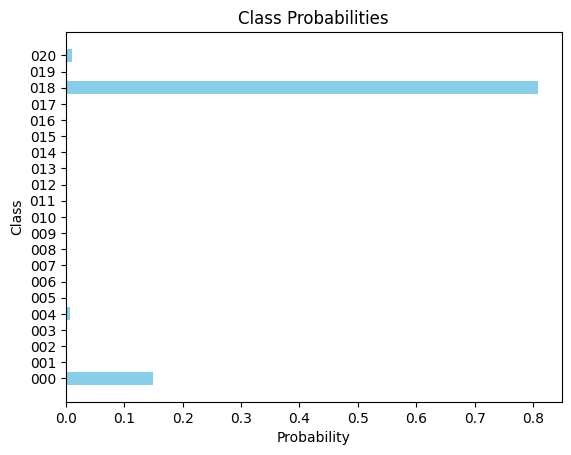

In [ ]:

import matplotlib.pyplot as plt
p1=spe_thers[6]
label_map = {}
for i in range(21):
          key = f"{i:03d}"
          label_map[key] = i
def plot_class_probabilities(class_probabilities, class_labels):
    # Plotting the class probabilities
    fig, ax = plt.subplots()
    ax.barh(list(class_labels.keys()), class_probabilities, color='skyblue')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Class')
    ax.set_title('Class Probabilities')
    plt.show()
plot_class_probabilities(p1, label_map)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
@Time : 2022/2/7 下午10:22
@Author : Yang "Jan" Xiao
@Description : keyword spotting model TC-ResNet.
Reference by https://github.com/Doyosae/Temporal-Convolution-Resnet
"""

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_keywords'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

    # Generate and print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_keywords'
    label_map = {}

    for i in range(21):
      key = f"{i:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_keywords'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset and generate confusion matrix
    test_saved_model('/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'000': 0, '001': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20}


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
#KWS

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = 20
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class KeywordSpottingDataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions
        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_keywords_without_000'
    label_map = {}

    for i in range(20):
      key = f"{i+1:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40 # frequency bands
    channels = [64, 128, 256, 512]  #output feature maps
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = KeywordSpottingDataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_without_000.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_keywords_without_000'
    validation_dataset = KeywordSpottingDataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/keyword_spotting_with_own_dataset_model_1_without_000.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19}


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/50], Loss: 2.9342483997344972
Epoch [2/50], Loss: 2.592533564567566
Epoch [3/50], Loss: 2.2977112770080566
Epoch [4/50], Loss: 1.9962242126464844
Epoch [5/50], Loss: 1.7233738541603087
Epoch [6/50], Loss: 1.5056581854820252
Epoch [7/50], Loss: 1.207076358795166
Epoch [8/50], Loss: 1.0087514817714691
Epoch [9/50], Loss: 0.8325359284877777
Epoch [10/50], Loss: 0.7686515033245087
Epoch [11/50], Loss: 0.6094645440578461
Epoch [12/50], Loss: 0.4858129233121872
Epoch [13/50], Loss: 0.3889848619699478
Epoch [14/50], Loss: 0.3022897019982338
Epoch [15/50], Loss: 0.26176210343837736
Epoch [16/50], Loss: 0.2467055931687355
Epoch [17/50], Loss: 0.1811039611697197
Epoch [18/50], Loss: 0.13822066634893418
Epoch [19/50], Loss: 0.10742488279938697
Epoch [20/50], Loss: 0.10312370471656322
Epoch [21/50], Loss: 0.08333307579159736
Epoch [22/50], Loss: 0.05808422788977623
Epoch [23/50], Loss: 0.044850390404462814
Epoch [24/50], Loss: 0.03935181461274624
Epoch [25/50], Loss: 0.029308479651808737


In [ ]:
 #Speaker Identifiction

import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset

# Define the TCResNet model
class TCResNet(nn.Module):
    def __init__(self, bins, channels, num_classes):
        super(TCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=(bins, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(channels[0])  # Batch normalization added
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=(0, 1))
        self.layer1 = self._make_layer(channels[0], channels[1], 2)
        self.layer2 = self._make_layer(channels[1], channels[2], 2)
        self.layer3 = self._make_layer(channels[2], channels[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[3], num_classes)

    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)))
        layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
        layers.append(nn.ReLU())
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=(1, 3), padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_channels))  # Batch normalization added
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization added
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the training loop
def train(model, dataloader, criterion, optimizer, device, num_epochs=10, weight_decay=0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute L2 regularization
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                l2_reg = l2_reg+torch.norm(param)
            loss += weight_decay * l2_reg

            loss.backward(retain_graph=True)  # Specify retain_graph=True
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}')

# Define the evaluation loop
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

# Define the function to test the saved model with the validation dataset
def test_saved_model(model_path, validation_dataloader, device):
    # Load the saved model
    data_dir = '/content/drive/MyDrive/testing_speakers_without_000'
    class_names=os.listdir(data_dir)
    label_map={class_name: idx for idx,class_name in enumerate(class_names)}
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Evaluate the model on the validation dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Validation Accuracy of the saved model: {accuracy:.2f}%')

class SP_ID_Dataset(Dataset):
    def __init__(self, data_dir, label_map, mfcc_window_size=0.025, mfcc_window_stride=0.01, mfcc_n_mels=40, fixed_length=500):
        self.data_dir = data_dir
        self.label_map = {str(k): v for k, v in label_map.items()}  # Convert keys to strings
        self.mfcc_window_size = mfcc_window_size
        self.mfcc_window_stride = mfcc_window_stride
        self.mfcc_n_mels = mfcc_n_mels
        self.fixed_length = fixed_length

        self.samples = []
        for label_str, label in self.label_map.items():
            label_dir = os.path.join(self.data_dir, label_str)
            for filename in os.listdir(label_dir):
                if filename.endswith('.wav'):
                    self.samples.append((os.path.join(label_dir, filename), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        mfcc = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=self.mfcc_n_mels,
            melkwargs={
                'win_length': int(self.mfcc_window_size * sample_rate),
                'hop_length': int(self.mfcc_window_stride * sample_rate),
            }
        )(waveform)

        # Pad or trim the MFCC tensor to fixed length
        mfcc = self.pad_or_trim_mfcc(mfcc)

        # Swap dimensions to match the expected shape by the model
        mfcc = mfcc.permute(0, 2, 1)  # Swap the last two dimensions

        return mfcc, label

    def pad_or_trim_mfcc(self, mfcc):
        # Get the current length of the MFCC tensor
        current_length = mfcc.size(2)

        # Pad or trim to fixed length
        if current_length < self.fixed_length:
            pad = torch.zeros(mfcc.size(0), mfcc.size(1), self.fixed_length - current_length)
            mfcc = torch.cat((mfcc, pad), dim=2)
        elif current_length > self.fixed_length:
            mfcc = mfcc[:, :, :self.fixed_length]

        return mfcc

def main():
    # Define the parameters
    data_dir = '/content/drive/MyDrive/training_speakers_without_000'
    label_map = {}
    for i in range(20):
      key = f"{i+1:03d}"
      label_map[key] = i
    print(label_map)
    bins = 40
    channels = [64, 128, 256, 512]
    channel_scale = 1
    num_classes = len(label_map)
    batch_size = 32
    num_epochs = 50
    learning_rate = 0.001
    fixed_length = 500

    # Create the dataset and dataloader for training
    dataset = SP_ID_Dataset(data_dir, label_map, fixed_length=fixed_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TCResNet(bins, [int(cha * channel_scale) for cha in channels], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, dataloader, criterion, optimizer, device, num_epochs)

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_without_unknown.pth')

    # Create the dataset and dataloader for validation
    validation_data_dir = '/content/drive/MyDrive/testing_speakers_without_000'
    validation_dataset = SP_ID_Dataset(validation_data_dir, label_map, fixed_length=fixed_length)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Test the saved model with the validation dataset
    test_saved_model('/content/drive/MyDrive/keyword_speakers_with_own_dataset_model_1_without_unknown.pth', validation_dataloader, device)

if __name__ == "__main__":
    main()


{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15, '017': 16, '018': 17, '019': 18, '020': 19}
Epoch [1/50], Loss: 2.571332597732544
Epoch [2/50], Loss: 1.8002379775047301
Epoch [3/50], Loss: 1.3154489398002625
Epoch [4/50], Loss: 0.9577666223049164
Epoch [5/50], Loss: 0.6951274067163468
Epoch [6/50], Loss: 0.488301956653595
Epoch [7/50], Loss: 0.40423802435398104
Epoch [8/50], Loss: 0.32378932237625124
Epoch [9/50], Loss: 0.2520218759775162
Epoch [10/50], Loss: 0.20089017003774642
Epoch [11/50], Loss: 0.17033570110797883
Epoch [12/50], Loss: 0.155753480643034
Epoch [13/50], Loss: 0.08630088567733765
Epoch [14/50], Loss: 0.0643706776201725
Epoch [15/50], Loss: 0.05059273298829794
Epoch [16/50], Loss: 0.0660213928669691
Epoch [17/50], Loss: 0.0438255600631237
Epoch [18/50], Loss: 0.029765952192246915
Epoch [19/50], Loss: 0.024378932360559703
Epoch [20/50], Loss: 0.01779262